In [20]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns


In [21]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [22]:
img_path_list = []
top_changed_img_path = "./data/box_img/Top_change_VS/"

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))

전처리한 이미지 RGB / HSV

In [23]:
top_avg_bgr = []
top_avg_hsv = []

for i in range(len(img_path_list)):
    # 이미지 로드
    img = cv2.cvtColor(np.array(Image.open(top_changed_img_path + 'Top_change_VS_{}.jpg'.format(i))), cv2.COLOR_RGB2BGR)
    # RGB 평균 계산
    avg_bgr = img.mean(axis=(0,1))
    top_avg_bgr.append(avg_bgr)
    # HSV 평균 계산
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = img_hsv.mean(axis=(0,1))
    top_avg_hsv.append(avg_hsv)

In [24]:
Table_dataset = pd.DataFrame({'Top_R' : [i[2] for i in top_avg_bgr], 
                              'Top_G' : [i[1] for i in top_avg_bgr], 
                              'Top_B' : [i[0] for i in top_avg_bgr],
                              'Top_H' : [i[0] for i in top_avg_hsv], 
                              'Top_S' : [i[1] for i in top_avg_hsv], 
                              'Top_V' : [i[2] for i in top_avg_hsv],
                              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,12.1656,11.7032,8.1244,23.5788,90.0008,12.3960,48.266667
1,12.4724,12.7284,11.0100,24.1728,39.9828,12.8452,47.966667
2,12.6808,12.6408,9.8016,29.8416,62.2292,12.8824,48.166667
3,11.1372,11.4652,8.5556,27.2936,68.9256,11.6236,48.600000
4,5.4440,3.1864,1.4096,30.2408,206.5236,5.5604,59.533333
...,...,...,...,...,...,...,...
122,0.4860,4.5392,22.1104,114.2120,249.3836,22.1104,84.633333
123,0.7240,15.4616,33.4912,106.3536,249.7260,33.4912,98.366667
124,0.9048,13.1052,38.7656,110.3592,249.1856,38.7656,97.033333
125,1.0604,13.6216,35.2664,108.8924,247.8428,35.2664,96.266667


원본 이미지 데이터 RGB/HSV

In [6]:
Top_path = './data/box_img/Top/'

top_org_avg_bgr = []
top_org_avg_hsv = []

for i in range(len(img_path_list)):
    # 이미지 로드
    img = cv2.cvtColor(np.array(Image.open(Top_path + 'Top_{}.jpg'.format(i))), cv2.COLOR_RGB2BGR)
    # RGB 평균 계산
    avg_bgr = img.mean(axis=(0,1))
    top_org_avg_bgr.append(avg_bgr)
    # HSV 평균 계산
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = img_hsv.mean(axis=(0,1))
    top_org_avg_hsv.append(avg_hsv)


In [7]:
orig_Table_dataset = pd.DataFrame({'Top_R' : [i[2] for i in top_org_avg_bgr], 
                              'Top_G' : [i[1] for i in top_org_avg_bgr], 
                              'Top_B' : [i[0] for i in top_org_avg_bgr],
                              'Top_H' : [i[0] for i in top_org_avg_hsv], 
                              'Top_S' : [i[1] for i in top_org_avg_hsv], 
                              'Top_V' : [i[2] for i in top_org_avg_hsv],
                              'Thickness': Thickness['Thickness']})

orig_Table_dataset

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,11.5760,10.8832,8.1364,22.0556,77.1296,11.5760,48.266667
1,12.4712,12.6248,11.2136,23.5584,34.0868,12.7416,47.966667
2,12.7704,12.7176,9.9168,29.7648,60.9592,12.9592,48.166667
3,11.2308,11.4564,8.8540,26.6792,61.8904,11.6148,48.600000
4,5.4696,3.2120,1.4352,30.2408,205.4796,5.5860,59.533333
...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,113.7544,248.4768,22.1704,84.633333
123,0.8864,15.7112,33.7552,106.3192,248.5092,33.7552,98.366667
124,1.0244,13.5756,38.8264,110.1980,248.5320,38.8264,97.033333
125,1.1264,13.7168,35.3488,108.8872,247.3560,35.3488,96.266667


H드랍

In [8]:
Table_dataset = Table_dataset.drop(['Top_H'], axis=1)
Table_dataset

,Top_R,Top_G,Top_B,Top_S,Top_V,Thickness
0,12.1656,11.7032,8.1244,90.0008,12.3960,48.266667
1,12.4724,12.7284,11.0100,39.9828,12.8452,47.966667
2,12.6808,12.6408,9.8016,62.2292,12.8824,48.166667
3,11.1372,11.4652,8.5556,68.9256,11.6236,48.600000
4,5.4440,3.1864,1.4096,206.5236,5.5604,59.533333
...,...,...,...,...,...,...
122,0.4860,4.5392,22.1104,249.3836,22.1104,84.633333
123,0.7240,15.4616,33.4912,249.7260,33.4912,98.366667
124,0.9048,13.1052,38.7656,249.1856,38.7656,97.033333
125,1.0604,13.6216,35.2664,247.8428,35.2664,96.266667


데이터 나누기

In [9]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:, :-1], Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

TPOT모델 찾기

# 🎯모델 1

In [10]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -72.46781988536719
                                                                             
Generation 2 - Current best internal CV score: -72.46781988536719
                                                                             
Generation 3 - Current best internal CV score: -50.63870228743585
                                                                             
Generation 4 - Current best internal CV score: -48.78935501622391
                                                                             
Best pipeline: AdaBoostRegressor(SelectFwe(input_matrix, alpha=0.004), learning_rate=1.0, loss=linear, n_estimators=100)


In [11]:
y_pred = tpot.predict(X_test)
y_pred

array([ 72.07333333,  62.81666667,  72.07333333,  96.81666667,
        91.51884058,  65.24444444,  72.07333333,  87.91311475,
        65.32941176, 109.87499998,  95.756     ,  62.58888889,
        83.568     ,  62.15555556,  83.08333333, 102.07000001,
        84.76190476,  83.08333333,  67.9       ,  82.32222222,
        70.99444444,  65.24444444,  83.70333333, 153.3       ,
        48.21111111, 116.95555557, 101.76333334, 101.76333334,
        72.07333333,  83.70333333,  63.16666667,  71.60333333,
        72.01481481, 109.87499998,  91.11041667, 101.66363638,
        72.01481481, 153.3       ,  75.38095238])

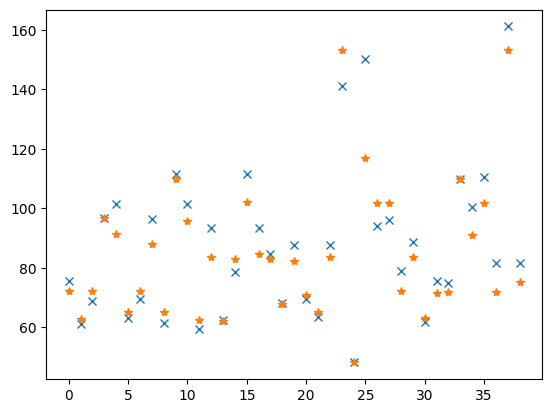

In [12]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [13]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.073333
1,61.300000,62.816667
2,68.700000,72.073333
3,96.633333,96.816667
4,101.466667,91.518841
5,63.166667,65.244444
6,69.433333,72.073333
7,96.266667,87.913115
8,61.466667,65.329412
9,111.533333,109.875000


In [14]:
mse = np.mean((y_pred - y_test)**2)
mse

61.44235055325415

# 🎯 모델 2

In [15]:
tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                             
Generation 1 - Current best internal CV score: -54.76358843819567
                                                                              
Generation 2 - Current best internal CV score: -52.508380476506865
                                                                              
Generation 3 - Current best internal CV score: -52.508380476506865
                                                                              
Generation 4 - Current best internal CV score: -52.202345269455336
                                                                              
Generation 5 - Current best internal CV score: -50.70971486820455
                                                                              
Best pipeline: AdaBoostRegressor(AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100), learning_rate=1.0, loss=linear, n_estimators=100)


In [16]:
y_pred = tpot.predict(X_test)
y_pred

/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


array([ 72.97058823,  62.63333333,  72.71568627,  99.11666669,
        98.67407408,  62.63333333,  72.55942029,  85.52269503,
        63.16666667, 110.34444443,  99.11666669,  62.5952381 ,
        81.15238095,  62.96666667,  84.53571429,  99.35666667,
        87.06380952,  82.5057971 ,  63.22      ,  80.78958333,
        65.11568627,  62.75238095,  87.3344086 , 153.3       ,
        48.45555556, 124.4333333 ,  99.18421053,  99.18421053,
        72.97058823,  87.3344086 ,  62.63333333,  74.17291666,
        72.20208333, 109.98333332,  98.64545455,  99.30000001,
        72.55942029, 124.4333333 ,  74.55444444])

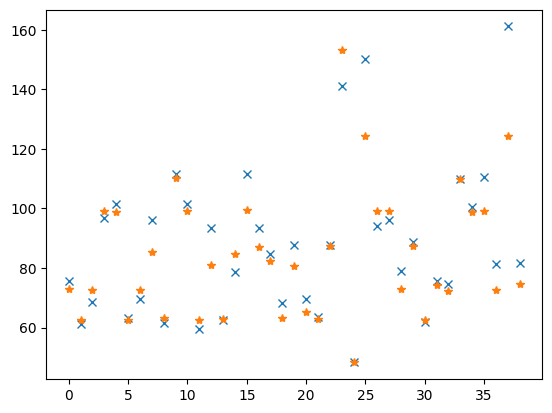

In [17]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [18]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.970588
1,61.300000,62.633333
2,68.700000,72.715686
3,96.633333,99.116667
4,101.466667,98.674074
5,63.166667,62.633333
6,69.433333,72.559420
7,96.266667,85.522695
8,61.466667,63.166667
9,111.533333,110.344444


In [19]:
mse = np.mean((y_test.values - y_pred)**2)
mse


80.89934461372205